# <div align="center"> 垃圾分类 </div>

In [43]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,pandas,matplotlib,sklearn,torch,torchvision

CPython 3.6.9
IPython 7.16.1

numpy 1.18.5
pandas 1.0.4
matplotlib 3.2.1
sklearn 0.0
torch 1.6.0.dev20200609+cu101
torchvision 0.7.0.dev20200609+cu101


In [74]:
import pandas as pd  
import argparse      
import shutil        
import os            
import random
import numpy as np
import json

import torch
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from k12libs.utils.nb_easy import K12AI_DATASETS_ROOT
from IPython.display import display
from PIL import Image

from torchvision.utils import make_grid

from k12libs.utils.nb_dataset import k12ai_compute_mean_std

In [3]:
dataset = 'rgarbage'
data_root = os.path.join(K12AI_DATASETS_ROOT, 'cv', dataset)
raw_path = os.path.join(data_root, 'raw')
img_path = os.path.join(data_root, 'imgs')

In [11]:
!ls $raw_path
!tree $raw_path/其他垃圾

其他垃圾  厨余垃圾  可回收物  有害垃圾
/bin/sh: 1: tree: not found


## 读取原始数据

In [68]:
name2label = {
    "其他垃圾": 0,
    "厨余垃圾": 1,
    "可回收物": 2,
    "有害垃圾": 3
}

label_image_dict = {}

# if os.path.exists(img_path):
#     shutil.rmtree(img_path)
# os.makedirs(img_path)

def scan_images(path):
    images = []
    with os.scandir(path) as it:
        for entry in it:
            if entry.is_dir():
                images.extend(scan_images(entry.path))
            else:
                images.append(entry.path[len(raw_path)+1:])
    return images

with os.scandir(raw_path) as it:
    for entry in it:
        if not entry.is_dir():
            continue
        label_image_dict[name2label[entry.name]] = scan_images(entry.path)
len(label_image_dict), len(label_image_dict[0]), label_image_dict.keys()

(4, 2524, dict_keys([2, 0, 1, 3]))

## 裁剪数据

In [71]:
label_images = {}
for label, files in label_image_dict.items():
    label_images[label] = []
    for path in files:
        dst = os.path.join(img_path, path)
        img = os.path.join(raw_path, path)
        if not os.path.exists(img):
            print(f'not passible: {img}')
        imgdir = os.path.dirname(dst)
        if not os.path.exists(imgdir):
            os.makedirs(imgdir)
        Image.open(img).resize((256, 256)).crop((16, 16, 240, 240)).save(dst)
        label_images[label].append(dst)
len(label_images), len(label_images[0])

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(4, 2524)

## 对比

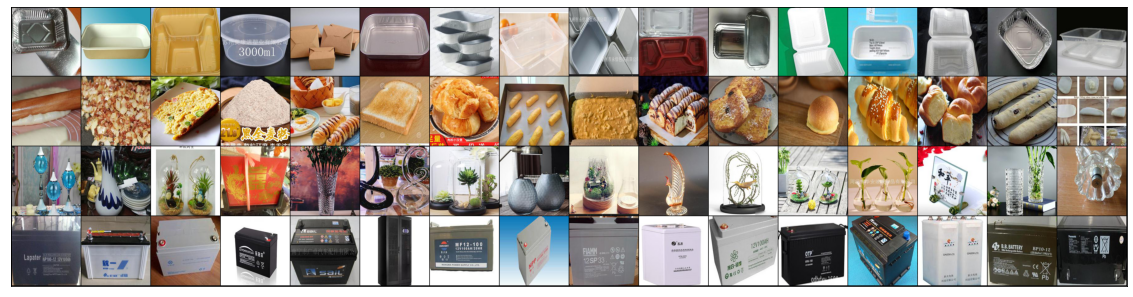

In [97]:
samples = []
for label in sorted(list(label_images.keys())):
    for img in label_images[label][:16]:
        samples.append(torch.from_numpy(np.asarray(Image.open(img))).permute(2, 0, 1))
    
fig, ax = plt.subplots(figsize=(20, 12))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(samples, nrow=16).permute(1, 2, 0))

## 切割数据集

In [98]:
# 6:2:2 split for train:valid:test dataset
test_images = []
valid_images = []
train_images = []
for label, files in label_images.items():
    for img in files:
        value = random.random()
        if value < 0.2: # test
            test_images.append((label, img))
        elif value < 0.4: # val
            valid_images.append((label, img))
        else: # train
            train_images.append((label, img))
test_count, val_count, train_count = len(test_images), len(valid_images), len(train_images)
test_count, val_count, train_count

(2131, 2206, 6736)

## 生成json文件

In [103]:
def generate_json_file(images, phase):
    prefix = len(data_root) + 1
    items = []
    for label, img in images:
        items.append({'image_path': img[prefix:], 'label': int(label)})
        
    random.shuffle(items)

    jsonfile = os.path.join(data_root, f'{phase}.json')
    with open(jsonfile, 'w', encoding='utf-8') as fp:
        json.dump(items, fp, ensure_ascii=False)
    return len(items)
        
# train.json
generate_json_file(train_images, 'train');

# val.json
generate_json_file(valid_images, 'val');

# test.json
generate_json_file(test_images, 'test');

In [100]:
jfiles = ['train.json', 'val.json', 'test.json']
mean, std = k12ai_compute_mean_std(datadir=data_root, jfiles=jfiles, resize=(224, 224))

## 生成info.json

In [105]:
label_names = list(name2label.keys())

info = {
    'num_records': test_count+val_count+train_count,
    'num_classes': len(label_names),
    'label_names': label_names,
    'mean': mean,
    'std': std,
}

with open(os.path.join(data_root, 'info.json'), 'w') as fw:
    json.dump(info, fw, ensure_ascii=False, indent=4)
    
info

{'num_records': 11073,
 'num_classes': 4,
 'label_names': ['其他垃圾', '厨余垃圾', '可回收物', '有害垃圾'],
 'mean': [0.6535, 0.6132, 0.5643],
 'std': [0.2165, 0.2244, 0.2416]}

## 数据平衡分析

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


<Figure size 432x288 with 0 Axes>

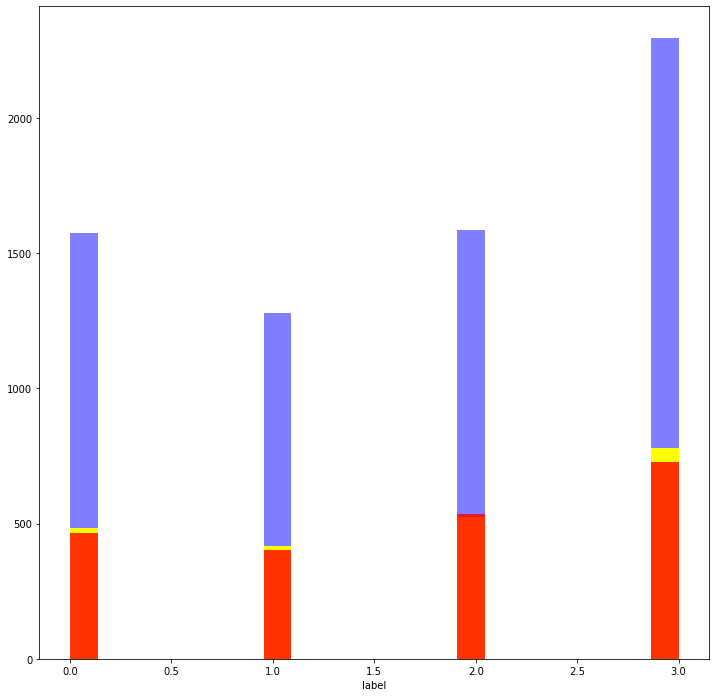

In [102]:
def draw_hist():
    plt.clf()
    fig = plt.figure(figsize=(12, 12))
    train_file = os.path.join(data_root, 'train.json')
    val_file = os.path.join(data_root, 'val.json')
    test_file = os.path.join(data_root, 'test.json')
    df_train = pd.read_json(train_file)
    df_val = pd.read_json(val_file)
    df_test = pd.read_json(test_file)
    for df, co, alpha in ((df_train, 'blue', 0.5), (df_val, 'yellow', 1), (df_test, 'red', 0.8)):
        sns.distplot(df['label'],
                 # fit=scipy.stats.norm,
                 kde=False,
                 hist=True,
                 hist_kws={"linewidth": 2, "alpha": alpha, 'color': co},
                 # rug=True,
                 bins=22)
    plt.savefig(f'{data_root}/labels_hist.png')
    plt.show()
draw_hist()

## References

[百度云](https://pan.baidu.com/s/1A5EQJvgdocid_zVj7CwGFA "提取码: tvun")